# Morocco Real Estate Data Exploration

I've managed to scrape just over 10k real estate listings from mubawab.ma - a moroccan property website. This notebook goes through some data cleaning and exploration to extract valuable insights on the property. The end goal is to develop a machine learning model that is able to accurately predict the price of a property based on several parameters, such as: city, property type, number of rooms, and amenities. Perhaps further down the line I might develop a reccomendation engine, that will suggest an area for you to live in based on your requirements and interests, we'll see!

## 1. Database to DataFrame

The data is stored in a PostgreSQL database hosted on AWS. The following section pulls the data into a pandas DataFrame.

In [1]:
import pandas as pd
import yaml
from sqlalchemy import create_engine

with open('/Users/adamidris/Coding/morocco-house-prediction/config/db_creds.yaml') as f:
    creds = yaml.safe_load(f)
    
user = creds['DB_USER']
password = creds['DB_PASS']
host = creds['DB_HOST']
port = creds['DB_PORT']
database = creds['DB_NAME']

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")
df = pd.read_sql_table('properties_for_rent', engine.connect())

I've pickled the df, so I don't have to read from the db every time.

In [2]:
import pandas as pd
df = pd.read_pickle('/Users/adamidris/Coding/morocco-house-prediction/data/processed/full_db.pkl')

## 2. Data Cleaning

Since the goal is to predict price, we should drop all the rows with missing prices. We can then observe the relationships between the different features of the property. 
Another thing to keep in mind is that many of the properties have 'daily rates' targeted at those who go back to Morocco for holiday. To filter those out, I will observe the distribution of prices and where they are mostly concentrated.

In [3]:
# Drop all rows with missing prices
df = df.dropna(subset='price')
df['price'] = df['price'].astype(int)
# Dropping some other unnecessary columns
df.drop(columns=['date_published', 'scraped_at', 'id'], inplace=True)

# Looking at stats for each of the numeric features
df.describe()

,size,rooms,bedrooms,bathrooms,price
count,9456.000000,9482.000000,9406.000000,9471.000000,9.566000e+03
mean,266.312394,3.644379,2.524134,2.051737,1.772130e+05
std,1646.398266,2.063205,1.151289,1.116009,3.980786e+06
min,12.000000,1.000000,1.000000,1.000000,1.500000e+02
25%,78.000000,2.000000,2.000000,1.000000,5.500000e+03
50%,110.000000,3.000000,2.000000,2.000000,9.000000e+03
75%,180.000000,5.000000,3.000000,2.000000,1.550000e+04
max,140140.000000,21.000000,18.000000,18.000000,2.000035e+08


### Initial Observations

- We can already see that the maximum size is an extremely weird number. 
- The **mean size** is significantly higher than the 75th percentile. The abnormally high size is skewing the data.
- The average property contains **3 rooms**, **2 bedrooms**, and **2 bathrooms**.
- The **minimum price** is **150 MAD** (~£12), which doesn't seem very realistic at all. We need to explore this a little more.
- The **maximum price** is over **200,000,000**, which also isn't realistic.

In [13]:
# Check out the highest prices by sorting the df
df.sort_values(by='price', ascending=False).head(10)

,title,description,property_type,city,area,size,rooms,bedrooms,bathrooms,price,features,condition,age,url
1627,Great apartment for rent in Ain Diab. Small ar...,"Rent your dream apartment. Price 20,000 DH. 4 ...",Apartment,Casablanca,Ain Diab,191.0,4.0,3.0,2.0,200003500,"Terrace, Garage, Elevator, Sea views, Concierg...",Good,5-10,https://www.mubawab.ma/en/a/7999171/great-apar...
1499,Flat for rent in Ferme Bretonne (Hay Arraha). ...,"Ideally located apartment for rent. Price 15,0...",Apartment,Casablanca,Ferme Bretonne (Hay Arraha),150.0,4.0,3.0,2.0,150003000,"Garage, Elevator, Concierge, Box room, Furnish...",Good,1-5,https://www.mubawab.ma/en/a/8001935/flat-for-r...
177,Apartment for rent in Casablanca Finance City....,"Beautifull apartment for rent. Price 12,200 DH...",Apartment,Casablanca,Casablanca Finance City,121.0,3.0,2.0,2.0,122001000,"Garden, Terrace, Garage, Elevator, Pool, Conci...",New,None,https://www.mubawab.ma/en/a/8025001/apartment-...
162,Apartment for rent in Casablanca Finance City....,"Ideal apartment for rent. Price 12,000 DH. 3 l...",Apartment,Casablanca,Casablanca Finance City,115.0,3.0,2.0,2.0,120001000,"Terrace, Garage, Elevator, Concierge, Box room...",New,None,https://www.mubawab.ma/en/a/8025073/apartment-...
170,Rent this apartment in Gauthier. 2 beautiful r...,Great amenities with this apartment for rent. ...,Apartment,Casablanca,Gauthier,130.0,4.0,2.0,3.0,105001000,"Terrace, Garage, Elevator, Concierge, Box room...",New,None,https://www.mubawab.ma/en/a/8025060/rent-this-...
169,Lovely apartment for rent in Racine. 3 rooms. ...,Great amenities with this apartment for rent. ...,Apartment,Casablanca,Racine,63.0,3.0,1.0,1.0,90001000,"Terrace, Garage, Elevator, Concierge, Box room...",New,None,https://www.mubawab.ma/en/a/8025062/lovely-apa...
154,Flat for rent in Oasis. 1 room. Furnishings.,"Beautifull apartment for rent. Price 8,500 DH....",Apartment,Casablanca,Oasis,60.0,2.0,1.0,1.0,85001000,"Terrace, Garage, Elevator, Concierge, Box room...",New,None,https://www.mubawab.ma/en/a/8025175/flat-for-r...
155,Great apartment for rent in Palmier. Dimension...,"Nice apartment for rent. Price 8,500 DH. 3 liv...",Apartment,Casablanca,Palmier,62.0,3.0,1.0,2.0,85001000,"Terrace, Garage, Elevator, Concierge, Box room...",New,None,https://www.mubawab.ma/en/a/8025174/great-apar...
171,Apartment for rent in Oasis. 1 lovely room. Fu...,"Ideal apartment for rent. Price 8,200 DH. 2 li...",Apartment,Casablanca,Oasis,66.0,2.0,1.0,1.0,82001000,"Terrace, Garage, Elevator, Concierge, Box room...",New,None,https://www.mubawab.ma/en/a/8025058/apartment-...
165,Flat for rent in Palmier. 1 lovely room. Stora...,Do not miss out on this apartment for rent. Pr...,Apartment,Casablanca,Palmier,57.0,2.0,1.0,1.0,77001000,"Terrace, Garage, Elevator, Concierge, Box room...",New,None,https://www.mubawab.ma/en/a/8025065/flat-for-r...


It's obvious that the price has been input incorrectly by accident as the description contains the actual prices. A common trend is that most of these prices end with '1000.' Let's observe all the unique values within the top 1% of prices.

In [21]:
percentile_99 = int(df.price.quantile(0.99))
df[df['price'] > percentile_99].sort_values('price', ascending=False)['price'].unique()

array([200003500, 150003000, 122001000, 120001000, 105001000,  90001000,
        85001000,  82001000,  77001000,  73001000,  55001000,  26000000,
        20000000,  17200000,  12000000,   9500000,   8900000,   7800000,
         7600000,   7450000,   7000500,   7000000,   6900000,   6500500,
         6500000,   5500500,   5000500,   4600400,   4600000,   4500500,
         4300000,   4000500,   3900000,   3800000,   3600000,   3200000,
         3150000,   3100000,   2600000,   2400000,   2350000,   2300000,
         2200000,   2100000,   1840000,   1800000,   1750000,   1700000,
         1600000,   1400000,   1300000,   1250000,   1200000,   1040000,
         1000000,    980000,    870000,    850000,    800000,    780000,
          779000,    750000,    720000,    680000,    600000,    480000,
          460000,    420000,    400000,    350000,    340000,    300001,
          300000,    260000,    245000,    220001,    190000,    185001,
          180000])

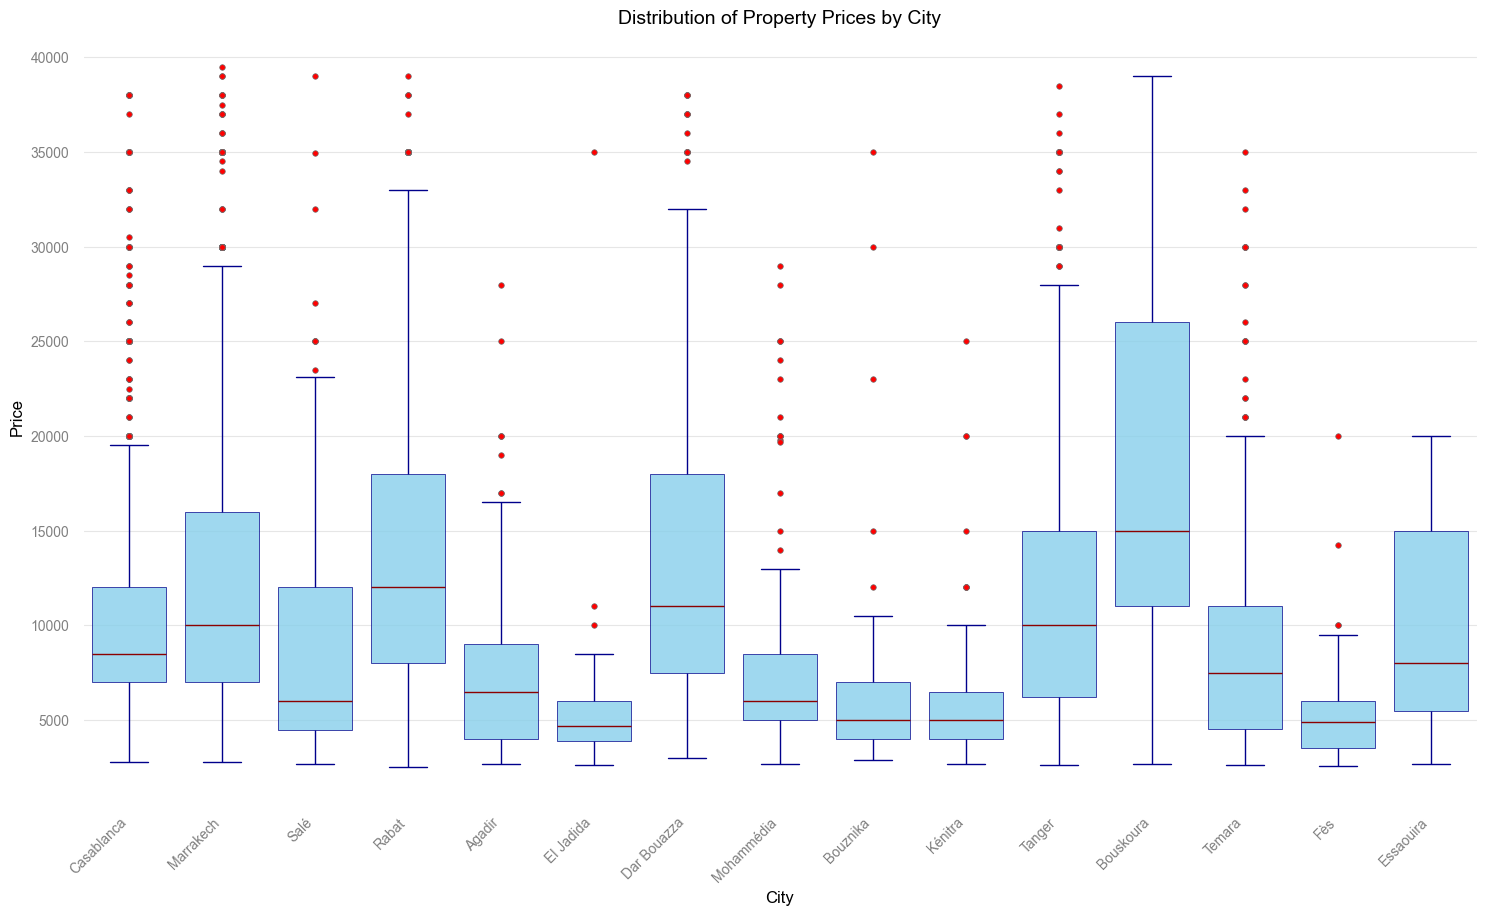

In [193]:
import seaborn as sns
import matplotlib.pyplot as plt

pop_cities = list(df.city.value_counts()[:15].index)
pop_cities_df = df[df['city'].isin(pop_cities)]
pop_cities_df = pop_cities_df[(pop_cities_df['price'] < 40000) & (pop_cities_df['price'] > 2500)]
sns.set_style("whitegrid", {"grid.color": ".9"})

sns.set_context("notebook", font_scale=0.9, rc={"grid.linewidth": 0.8})

# Plot
fig = plt.figure(figsize=(18, 10))
sns.boxplot(x='city', y='price', data=pop_cities_df, 
            color='skyblue', 
            boxprops=dict(facecolor=(0.53, 0.81, 0.92, 0.8), edgecolor="darkblue", linewidth=0.5),
            whiskerprops=dict(color="darkblue"),
            capprops=dict(color="darkblue"),
            medianprops=dict(color="darkred", linewidth=1),
            flierprops=dict(marker='o', color='red', markersize=4, markerfacecolor='red', markeredgewidth=0.5))

# Customizing the plot
plt.title("Distribution of Property Prices by City", fontsize=14, color="black")
plt.xlabel("City", fontsize=12, color="black")
plt.ylabel("Price", fontsize=12, color="black")
plt.xticks(rotation=45, ha='right', fontsize=10, color="grey")
plt.yticks(fontsize=10, color="grey")

for spine in plt.gca().spines.values():
    spine.set_color("white")  
    spine.set_linewidth(1.5)    

plt.show()

In [194]:
pop_cities_df = pop_cities_df[pop_cities_df['size'] < 300]

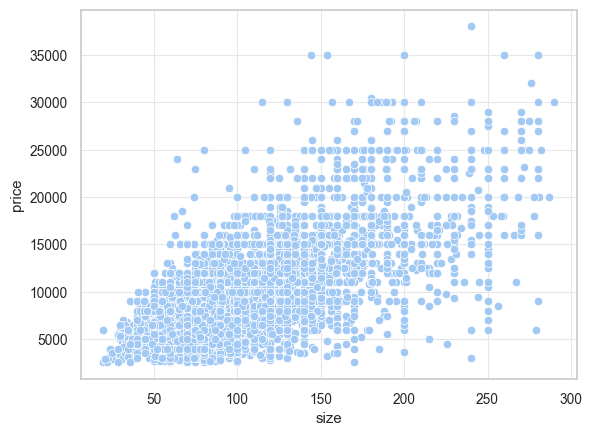

In [198]:
import numpy as np

sns.scatterplot(x='size', y='price', data=pop_cities_df[pop_cities_df['property_type'] == 'Apartment'])
plt.show()

<Axes: xlabel='log_price', ylabel='Count'>

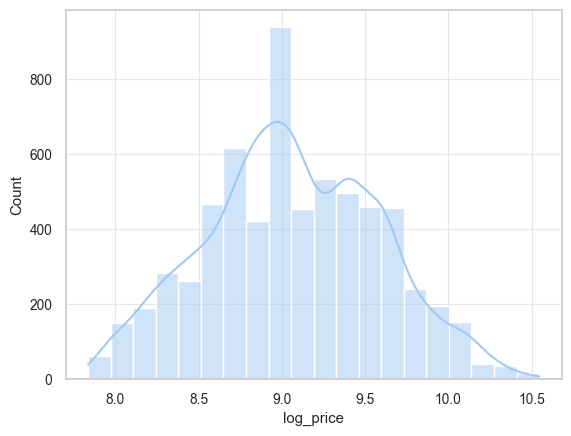

In [197]:
pop_cities_df['log_price'] = np.log1p(pop_cities_df['price'])
sns.histplot(pop_cities_df['log_price'], bins=20, kde=True)